In [75]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [76]:
from fastai.text import *
import torch

In [77]:
import fastai
fastai.__version__

'1.0.42'

In [78]:
# defaults.device = torch.device('cpu')
# defaults.device

device(type='cpu')

In [79]:
df = pd.read_csv('./Final_Intent_Dataset.csv')
#df = pd.read_csv('./Common_train_valid_dataset.csv')
df.head()

,label,text,is_valid
0,account_blocked,why is there a hold on my american saving bank...,True
1,account_blocked,i am nost sure why my account is blocked,True
2,account_blocked,why is there a hold on my capital one checking...,True
3,account_blocked,i think my account is blocked but i do not kno...,True
4,account_blocked,can you tell me why is my bank account frozen,True


In [80]:
df['text'][1]

'i am nost sure why my account is blocked'

In [81]:
path = '/notebooks/storage/'

### Language Model

In [82]:
data_lm = TextDataBunch.from_csv(path, 'Final_Intent_Dataset.csv')
#data_lm = TextDataBunch.from_csv(path, 'Common_train_valid_dataset.csv')

In [83]:
data_lm.save('tmp_lm')

In [84]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=32)

In [85]:
data_lm.show_batch()

idx,text
0,some more checks for my bank of the west account xxbos how do i go about getting direct deposit in my usaa account xxbos send me xxunk of how to do a xxunk xxunk xxbos does xxunk xxunk any better plans than the one i 'm on xxbos where do i redeem my credit card points xxbos what 's the blue book value of my car xxbos place a block
1,rate between usd and xxunk xxbos dollar to pesos exchange rate xxbos how long does it take to get a divorce xxunk xxbos how many people xxunk from mental illness xxbos create a for - while xxunk that xxunk 10 times xxbos what is my interest rate payment xxbos do you know the expiration date that is on my visa card xxbos what 's the xxunk time it takes for
2,"do i have to do to use my credit points xxunk through purchases xxbos show me my credit score xxbos my account is blocked , help me figure out why xxbos tell me the month my card expires xxbos please make a report that my card is split xxbos how many steps have i taken today xxbos what 's my current limit on my visa xxbos is the movie xxunk"
3,"my bank of america card i do n't recognize xxbos will you let me know my bank balance xxbos i need my savings account placed under a block as soon as possible xxbos ai , where do i go to order checks for my usbank account xxbos i need my money to be xxunk xxbos i have to transfer from one account to my other one xxbos please tell me"
4,card xxbos my credit score xxunk but i do n't know how to improve it xxbos what is my limit on my visa card xxbos what is my maurices card 's rewards balance xxbos give me the date my bill is due xxbos can you find the expiration date and tell me what it is that is on my visa credit card xxbos where are most the xxunk right now


In [86]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'my',
 'i']

In [87]:
data_lm.train_ds[0][0]

Text xxbos what is one xxunk xxunk

In [88]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [89]:
#learn.save_encoder('LM_encoder')

In [90]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


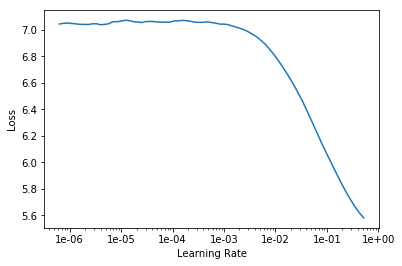

In [91]:
learn.recorder.plot(skip_end=15)

In [92]:
learn.fit_one_cycle(1, 1e-01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.921305,2.849758,0.386086


In [93]:
#learn.save('fit_head')

In [94]:
#learn.load('fit_head')

In [95]:
learn.unfreeze()

In [96]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.767934,2.528121,0.437574


In [97]:
#learn.save('fine_tuned')

In [98]:
#learn.load('fine_tuned')

In [99]:
TEXT = "What is the credit"
N_WORDS = 10
N_SENTENCES = 1

In [100]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

What is the credit limit on my discover card xxbos how long to wait


In [101]:
learn.save_encoder('LM_fine_tuned_encoder')

### Classifier

In [102]:
data_clas = (TextList.from_csv(path, 'Final_Intent_Dataset.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())
# data_clas = (TextList.from_csv(path, 'Common_train_valid_dataset.csv', cols='text')
#                 .split_from_df(col=2)
#                 .label_from_df(cols=0)
#                 .databunch())

In [103]:
data_clas = TextClasDataBunch.from_csv(path, 'Final_Intent_Dataset.csv', vocab=data_lm.train_ds.vocab, bs=32)
#data_clas = TextClasDataBunch.from_csv(path, 'Common_train_valid_dataset.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [104]:
data_clas.save('tmp_clas')

In [105]:
data_clas.show_batch()

text,target
xxbos i have n't heard if my application for a credit card has been accepted or not can you check on it for me,application_status
xxbos i keep trying to figure out if i have enough money in my chase account to purchase a new set of xxunk,balance
xxbos can you tell me if my application for a credit card has been processed yet it was at chase bank,application_status
xxbos can you show me how to set up my paycheck to be direct deposit to my first hawaiian bank account,direct_deposit
xxbos can you show me how to set up direct deposit for my paycheck to my first hawaiian bank account,direct_deposit


In [106]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('LM_fine_tuned_encoder')
#learn.load_encoder('LM_encoder')

In [107]:
learn.freeze()

In [108]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


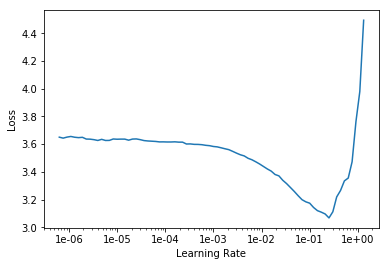

In [109]:
learn.recorder.plot()

In [110]:
learn.fit_one_cycle(10, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.390879,0.670045,0.809135
2,1.152377,0.539498,0.844209
3,0.981496,0.452856,0.863785
4,0.949314,0.402397,0.884176
5,0.829677,0.383547,0.883361
6,0.739083,0.310693,0.911093
7,0.648378,0.287902,0.911093
8,0.570783,0.286348,0.911909
9,0.522267,0.251268,0.924959
10,0.548484,0.253574,0.925775


In [111]:
#learn.save('after-first-training')

In [112]:
#learn.load('after-first-training')

In [113]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.527884,0.259525,0.924144


In [114]:
#learn.save('after-second-training')

In [115]:
#learn.load('after-second-training')

In [116]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.381940,0.199773,0.942088


In [117]:
#learn.save('after-third-training')

In [118]:
#learn.load('after-third-training')

In [119]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.283894,0.186200,0.946982
2,0.247262,0.179175,0.951876
3,0.221438,0.171472,0.952692
4,0.220010,0.166638,0.951060
5,0.205264,0.168112,0.949429


In [120]:
learn.predict("why can't i access my chase account")

(Category account_blocked,
 tensor(0),
 tensor([9.9965e-01, 2.0996e-08, 1.5760e-07, 6.3219e-07, 1.6889e-08, 8.5861e-07,
         3.0492e-04, 1.0830e-07, 7.3658e-09, 3.0605e-07, 5.3319e-06, 8.2683e-07,
         2.7276e-07, 1.3439e-07, 1.8352e-05, 4.0424e-07, 5.4551e-08, 1.3312e-08,
         9.6208e-07, 2.5186e-09, 1.0037e-08, 5.7745e-08, 2.1682e-06, 3.5704e-08,
         7.9869e-08, 7.1137e-06, 8.9876e-08, 7.4738e-08, 2.5107e-07, 6.0874e-07,
         8.3827e-07, 1.2265e-06, 1.0596e-07, 4.7598e-09, 1.7974e-08]))

In [121]:
learn.predict("has my mastercard application gone through the process")

(Category application_status,
 tensor(1),
 tensor([2.2227e-09, 9.9999e-01, 6.0509e-09, 3.4462e-11, 3.0180e-09, 7.9526e-08,
         1.1668e-10, 7.6684e-09, 6.5754e-09, 7.8260e-09, 1.4737e-07, 5.0235e-08,
         1.5712e-11, 3.9635e-07, 4.5984e-09, 1.1087e-10, 6.8539e-09, 5.2181e-09,
         2.5272e-11, 8.9211e-08, 1.9579e-08, 3.1315e-06, 4.7772e-07, 2.9194e-08,
         1.2882e-07, 1.1361e-10, 6.5274e-08, 5.2173e-07, 4.1696e-11, 4.3359e-09,
         2.3895e-08, 5.0179e-10, 7.0295e-11, 9.4443e-09, 5.3337e-11]))

In [122]:
learn.predict("what's the apr on my capital one venture card")

(Category apr,
 tensor(2),
 tensor([1.6404e-07, 3.8369e-08, 9.9996e-01, 2.8376e-07, 3.6506e-06, 2.9087e-09,
         6.4801e-09, 4.8064e-06, 1.0540e-09, 3.2797e-08, 1.9689e-08, 3.9109e-10,
         4.8931e-08, 8.2509e-07, 3.2299e-09, 7.5013e-09, 1.0959e-08, 6.5414e-10,
         2.2125e-05, 1.3589e-07, 9.2098e-08, 2.9777e-09, 1.9280e-07, 2.3153e-10,
         1.2938e-10, 9.2366e-08, 5.5790e-08, 1.7714e-06, 1.1688e-07, 7.8948e-09,
         1.1195e-06, 5.9264e-11, 5.0590e-06, 2.7253e-07, 2.6850e-10]))

In [123]:
learn.predict("what if i want to switch insurance plans")

(Category insurance_change,
 tensor(17),
 tensor([3.0897e-09, 2.5274e-08, 1.0128e-09, 1.6151e-08, 2.6375e-09, 4.5407e-07,
         4.7842e-10, 5.1918e-11, 8.5672e-08, 4.1517e-09, 1.1325e-10, 1.4530e-06,
         3.5163e-08, 1.0896e-08, 4.9005e-10, 2.2792e-06, 2.3058e-04, 9.9976e-01,
         2.2431e-09, 4.8532e-09, 1.5481e-08, 4.0420e-06, 2.3081e-06, 1.7712e-08,
         2.6729e-08, 2.4148e-08, 2.3113e-07, 7.7182e-08, 4.5514e-09, 3.5390e-09,
         2.0075e-07, 5.6154e-07, 9.3562e-09, 8.4639e-09, 5.6916e-08]))

In [124]:
learn.predict("how do i apply for a visa card")

(Category new_card,
 tensor(21),
 tensor([1.8886e-12, 1.2297e-06, 9.4334e-09, 5.1130e-11, 2.4263e-09, 3.2216e-09,
         6.7883e-11, 3.2340e-08, 1.3081e-08, 2.3967e-08, 3.6625e-09, 5.9342e-09,
         6.6293e-11, 1.5865e-08, 2.0676e-12, 6.9584e-11, 3.2691e-09, 3.3527e-07,
         2.1180e-10, 6.4167e-10, 3.7850e-11, 9.9998e-01, 1.8627e-08, 8.9913e-09,
         3.5626e-09, 5.6556e-10, 1.2959e-05, 7.3596e-07, 2.4233e-11, 1.0825e-07,
         3.0232e-07, 2.7887e-10, 1.4578e-10, 8.1969e-11, 1.7901e-13]))

In [125]:
learn.predict("what points have i earned on my visa")

(Category rewards_balance,
 tensor(30),
 tensor([1.6648e-08, 1.0155e-07, 5.6182e-06, 2.6712e-06, 4.6556e-08, 6.6862e-09,
         8.1271e-09, 1.3460e-05, 5.3256e-09, 6.2711e-08, 2.1815e-10, 3.6480e-09,
         8.8956e-09, 3.3788e-09, 1.1055e-10, 8.9809e-10, 2.2313e-05, 6.2490e-09,
         2.9108e-08, 6.3940e-09, 9.9772e-09, 8.1854e-08, 8.7511e-08, 8.4728e-09,
         2.5124e-11, 1.8945e-09, 2.5379e-04, 3.0694e-09, 2.7150e-08, 6.8572e-09,
         9.9970e-01, 2.5142e-11, 9.7865e-08, 3.1401e-06, 2.9773e-12]))

In [126]:
learn.predict("if i lose my job will my credit score go down")

(Category improve_credit_score,
 tensor(15),
 tensor([9.0900e-06, 1.2870e-05, 3.7589e-05, 8.5868e-09, 1.3025e-08, 4.4483e-07,
         1.1176e-05, 5.4165e-06, 3.3530e-05, 1.2027e-01, 3.4261e-05, 1.4203e-07,
         5.3181e-09, 1.9691e-05, 3.5259e-06, 8.7954e-01, 5.5960e-08, 4.7964e-08,
         2.2048e-08, 5.9740e-08, 2.0099e-08, 6.4138e-06, 3.6119e-06, 2.4421e-09,
         6.5102e-07, 3.9413e-08, 3.4581e-06, 6.8045e-06, 7.8230e-08, 1.1390e-06,
         2.8945e-08, 9.3960e-07, 4.8803e-08, 9.9317e-09, 2.2226e-08]))

In [127]:
learn.predict("can i initiate a one-time transfer from my savings account to my money market account")

(Category transfer,
 tensor(34),
 tensor([1.2109e-04, 3.5730e-07, 7.5203e-07, 6.1817e-05, 2.8754e-06, 8.0990e-06,
         4.3117e-07, 1.3734e-06, 4.1063e-05, 7.9199e-07, 2.3341e-05, 3.8721e-05,
         8.2356e-05, 6.8483e-06, 1.6316e-03, 2.6475e-05, 8.6284e-08, 1.0295e-05,
         3.7702e-05, 8.4982e-06, 6.8868e-05, 1.5512e-06, 2.3089e-03, 3.7968e-06,
         4.4524e-03, 1.4490e-04, 1.2845e-06, 1.1937e-04, 6.4616e-05, 9.9247e-07,
         8.5981e-08, 7.5211e-05, 7.1797e-05, 7.6760e-06, 9.9057e-01]))

In [128]:
learn.predict("i need to see all visa purchases for march")

(Category transactions,
 tensor(33),
 tensor([1.4414e-07, 1.4613e-04, 1.7139e-05, 4.0340e-05, 6.7212e-04, 3.2288e-05,
         9.7457e-07, 5.7747e-05, 1.9016e-06, 2.7743e-07, 5.0399e-06, 8.1410e-09,
         1.8709e-04, 2.9958e-04, 2.5167e-07, 1.4905e-08, 3.1311e-05, 3.0289e-05,
         1.1484e-06, 5.3052e-05, 9.5118e-06, 5.9814e-05, 3.5391e-03, 3.6996e-06,
         3.9475e-07, 6.6525e-07, 1.0177e-04, 5.9099e-06, 7.2743e-05, 9.8846e-06,
         1.8564e-04, 2.2930e-07, 3.2144e-06, 9.9443e-01, 3.7024e-07]))

In [129]:
learn.export('/notebooks/storage/ULMFiT_classifier_model_cpu.pkl')

In [130]:
my_path = learn.path

In [131]:
my_learn = load_learner(my_path, 'ULMFiT_classifier_model_cpu.pkl')

In [132]:
my_learn.predict("how do i report the card as lost")

(Category report_lost_card,
 tensor(29),
 tensor([1.0567e-11, 1.6302e-12, 1.0909e-09, 1.4714e-13, 6.4940e-10, 3.5279e-13,
         6.3915e-10, 6.9911e-13, 5.0497e-15, 8.8139e-12, 2.9844e-04, 1.1522e-12,
         3.9803e-11, 1.1619e-10, 9.0613e-13, 2.6374e-12, 2.2994e-11, 1.3405e-11,
         7.2643e-14, 4.1913e-12, 9.0196e-15, 1.0094e-09, 1.1850e-10, 2.9964e-12,
         9.4540e-14, 1.0937e-13, 1.7326e-09, 5.0605e-08, 1.7532e-09, 9.9970e-01,
         1.4656e-10, 5.0472e-11, 5.9180e-10, 8.2681e-14, 4.1952e-14]))

In [133]:
my_learn.predict("can you explain a good risk strategy to me")

(Category oos,
 tensor(22),
 tensor([1.2322e-04, 8.1057e-05, 2.9401e-05, 3.5216e-05, 3.2897e-05, 1.5496e-05,
         9.0543e-07, 3.9068e-06, 9.3957e-07, 5.1534e-06, 1.5997e-04, 3.9339e-05,
         4.5836e-05, 4.2493e-06, 2.4612e-05, 1.3452e-05, 2.0038e-04, 5.5605e-04,
         5.0401e-06, 1.4824e-06, 5.1975e-06, 2.6547e-03, 9.9493e-01, 1.1990e-05,
         2.9983e-06, 1.4043e-05, 2.1502e-06, 8.0564e-04, 1.2022e-05, 9.4100e-05,
         7.3882e-06, 1.4799e-05, 6.0316e-05, 3.6682e-06, 2.3886e-06]))

In [134]:
my_learn.predict("whens my insurance due and how much does it cost")

(Category bill_due,
 tensor(5),
 tensor([2.4927e-06, 2.5346e-04, 1.7664e-05, 5.7111e-06, 3.4399e-01, 5.7473e-01,
         8.5669e-07, 2.5718e-04, 2.1085e-07, 1.8072e-05, 5.5624e-06, 6.9069e-06,
         1.8323e-05, 1.0799e-02, 9.6312e-09, 2.0982e-07, 6.7180e-02, 5.4859e-04,
         6.1141e-06, 1.6727e-05, 3.4765e-04, 3.0149e-06, 8.4498e-04, 1.1766e-06,
         2.3293e-05, 1.3437e-06, 3.1306e-06, 4.4208e-04, 1.6579e-07, 1.9839e-05,
         2.5088e-04, 8.9328e-07, 1.8723e-04, 1.8495e-05, 5.9051e-08]))

In [135]:
my_learn.predict("tell me my hsbc card credit limit")

(Category credit_limit,
 tensor(7),
 tensor([3.1005e-08, 5.3919e-05, 1.3282e-04, 2.6086e-07, 4.5753e-07, 6.9458e-07,
         1.6472e-07, 9.9946e-01, 8.8011e-06, 5.1975e-05, 6.3649e-08, 8.6621e-10,
         8.4647e-09, 2.3399e-04, 6.0443e-10, 1.8211e-08, 2.6224e-07, 3.6392e-09,
         1.4336e-06, 3.1550e-07, 1.2793e-07, 5.8523e-07, 3.2221e-07, 6.6346e-09,
         1.2596e-09, 4.5927e-06, 5.2277e-07, 2.5699e-06, 4.2350e-08, 2.2856e-08,
         4.4755e-05, 1.1975e-09, 1.2004e-07, 7.9720e-07, 6.9407e-10]))

In [136]:
my_learn.predict("when does my gas bill need paid by")

(Category bill_due,
 tensor(5),
 tensor([1.5173e-09, 2.5697e-06, 1.3616e-09, 3.4509e-11, 1.0783e-04, 9.9946e-01,
         9.1663e-10, 4.3880e-09, 8.7610e-11, 1.2039e-09, 6.0481e-08, 1.2041e-08,
         2.6636e-10, 1.7313e-04, 4.0710e-10, 3.7739e-09, 2.5236e-09, 1.9095e-10,
         7.9920e-09, 2.9114e-08, 7.8585e-06, 1.4280e-08, 1.5888e-06, 4.7067e-09,
         1.5398e-05, 4.6193e-11, 1.4132e-10, 2.2808e-04, 1.4171e-10, 1.0133e-08,
         1.8574e-09, 5.2538e-08, 2.2611e-07, 2.0485e-10, 4.5575e-10]))

In [137]:
my_learn.predict("i accidentally deactivated the magnetic stripe on my visa debit card and i need to report it")

(Category damaged_card,
 tensor(10),
 tensor([4.5252e-06, 6.9511e-06, 7.5980e-05, 4.5262e-06, 5.8586e-05, 5.2645e-06,
         3.2051e-05, 1.9756e-05, 9.2739e-07, 3.8131e-05, 6.4279e-01, 1.0998e-07,
         5.4533e-07, 3.2874e-05, 5.9468e-05, 2.0437e-06, 4.0047e-06, 2.0222e-05,
         1.1851e-06, 2.2686e-05, 5.1655e-06, 7.1859e-05, 3.6442e-04, 2.7315e-07,
         1.3272e-04, 1.7789e-06, 2.5774e-06, 1.0164e-04, 9.6582e-02, 2.5894e-01,
         1.7494e-06, 4.6711e-05, 9.3158e-06, 5.5593e-04, 4.6846e-06]))

In [138]:
my_learn.predict("is $30 usd more or less in canada")

(Category exchange_rate,
 tensor(12),
 tensor([1.7207e-06, 9.7406e-09, 1.1441e-07, 7.2352e-04, 3.6836e-05, 2.6673e-06,
         2.8063e-08, 3.4215e-07, 2.8500e-06, 3.2473e-07, 2.5707e-06, 1.8319e-05,
         7.8679e-01, 1.6246e-06, 1.0535e-06, 5.0090e-06, 1.4967e-07, 9.1064e-07,
         4.8609e-06, 5.8654e-05, 4.9623e-06, 4.4123e-06, 1.0744e-02, 3.7898e-05,
         5.4956e-05, 9.5949e-08, 2.9656e-07, 5.3022e-06, 1.0016e-06, 5.2878e-07,
         7.6710e-08, 6.3630e-06, 3.3363e-06, 3.7484e-06, 2.0148e-01]))

In [139]:
my_learn.predict("how do i order more checkbooks for my well's fargo account")

(Category order_checks,
 tensor(23),
 tensor([7.5022e-11, 1.3173e-11, 1.5273e-13, 9.0047e-09, 9.2763e-09, 1.5183e-10,
         9.7425e-14, 6.7122e-13, 7.8024e-12, 2.7576e-12, 8.7909e-12, 2.5186e-09,
         7.4374e-12, 3.5647e-12, 1.8006e-10, 2.8852e-12, 3.0475e-10, 5.8633e-10,
         1.3983e-10, 9.0026e-13, 6.5028e-11, 1.0618e-10, 2.1887e-09, 1.0000e+00,
         6.0985e-10, 1.9136e-10, 1.8814e-08, 1.1876e-10, 1.7255e-11, 1.1879e-10,
         7.0902e-09, 1.2912e-10, 4.8740e-11, 4.9676e-10, 3.8813e-10]))

In [140]:
my_learn.predict("Whose name is on the bill")

(Category pay_bill,
 tensor(24),
 tensor([5.3514e-05, 1.2056e-04, 1.2065e-03, 6.1030e-06, 1.5066e-01, 1.6153e-01,
         2.6522e-04, 3.9578e-04, 1.2854e-04, 5.0694e-04, 4.6351e-03, 6.7741e-04,
         3.0253e-04, 2.3997e-04, 7.4624e-05, 4.3417e-04, 4.9638e-05, 5.5549e-05,
         3.7219e-04, 1.2031e-04, 6.5473e-02, 4.6059e-04, 5.8890e-02, 1.6046e-05,
         5.4950e-01, 6.4628e-05, 5.6422e-05, 1.1194e-03, 4.1267e-04, 5.7565e-05,
         2.0677e-06, 6.3028e-05, 1.5454e-03, 2.1812e-04, 2.8239e-04]))

In [141]:
my_learn.predict("What is the procedure to surrender a credit card")

(Category new_card,
 tensor(21),
 tensor([5.1353e-06, 5.7881e-04, 2.1906e-02, 1.8767e-07, 1.9456e-05, 2.4539e-04,
         1.8175e-03, 2.2384e-03, 1.3306e-03, 5.3529e-03, 1.1741e-02, 4.1143e-06,
         1.1812e-05, 2.3942e-02, 4.6842e-06, 4.1869e-02, 7.3792e-06, 1.3652e-05,
         6.2708e-06, 9.2416e-06, 1.0749e-05, 5.8271e-01, 1.5647e-02, 7.8782e-07,
         3.0167e-05, 3.2221e-06, 1.7606e-03, 2.8770e-01, 8.1012e-06, 9.2948e-04,
         1.0143e-05, 3.8146e-05, 4.7949e-05, 3.4337e-06, 4.3814e-06]))

In [142]:
my_learn.predict("What is the pin number")

(Category pin_change,
 tensor(25),
 tensor([9.3696e-10, 4.4089e-10, 1.1906e-07, 1.0513e-09, 7.5399e-10, 1.8588e-08,
         1.3580e-09, 1.6869e-06, 3.1342e-09, 1.1745e-08, 9.2503e-11, 3.5429e-10,
         2.9220e-10, 6.9045e-09, 2.1539e-10, 2.5726e-10, 9.7975e-10, 4.2183e-10,
         4.1141e-08, 2.2331e-11, 2.4279e-09, 1.9646e-10, 1.5790e-07, 2.2868e-09,
         1.1961e-10, 1.0000e+00, 1.0694e-11, 1.3704e-07, 3.8892e-12, 2.4729e-11,
         2.3623e-10, 2.5262e-09, 6.1383e-08, 1.8559e-11, 1.7560e-10]))

In [143]:
my_learn.predict("What is the procedure for printing business card")

(Category oos,
 tensor(22),
 tensor([2.1820e-04, 1.2939e-02, 9.3434e-04, 4.3760e-05, 9.4542e-05, 1.3509e-04,
         2.8874e-03, 6.4963e-04, 5.2115e-04, 1.3963e-04, 2.5570e-04, 1.6481e-03,
         3.3483e-04, 3.5932e-02, 9.0879e-06, 1.4007e-03, 5.0264e-04, 4.5053e-03,
         5.0829e-05, 4.1576e-03, 2.9396e-05, 7.3779e-02, 6.2534e-01, 3.1728e-04,
         4.2593e-06, 1.2551e-04, 2.7631e-04, 2.3171e-01, 1.7712e-05, 3.3066e-04,
         6.8153e-05, 2.7893e-04, 2.8420e-04, 5.6294e-05, 2.0786e-05]))

In [144]:
my_learn.predict("Does banking interest you")

(Category interest_rate,
 tensor(18),
 tensor([2.3138e-09, 1.8427e-11, 8.8533e-08, 1.5673e-09, 2.3137e-08, 9.1236e-09,
         1.1858e-08, 1.0320e-09, 2.7603e-10, 8.4754e-09, 8.2763e-10, 1.5430e-08,
         2.5895e-06, 4.4329e-09, 5.6261e-10, 3.2874e-09, 1.1079e-08, 5.5533e-08,
         9.9995e-01, 1.2887e-07, 7.3120e-10, 1.5312e-07, 4.6021e-05, 1.2435e-08,
         7.8512e-09, 3.1147e-09, 3.6325e-08, 5.8478e-07, 3.2451e-09, 2.9543e-11,
         7.3598e-11, 7.8675e-09, 5.2954e-07, 5.9939e-09, 1.1954e-08]))

In [145]:
df_test = pd.read_csv('./Test_Intent_Dataset.csv')
#df_test = pd.read_csv('./Common_test_dataset.csv')
df_test.head()

,label,text
0,account_blocked,can you help me unblock my account
1,account_blocked,can you check what the problem with my account...
2,account_blocked,is there a reason you put a hold on my chase a...
3,account_blocked,why can't i access my chase account
4,account_blocked,how come my chase account has a hold on it


In [146]:
my_file_1 = open('ulmfit_predictions_1.json', 'w')
total_preds = 0
correct_preds = 0
# print("Query,True_label,Prediction,Score", file = my_file_1)
print("predict_response = [", file = my_file_1)
for index, row in df_test.iterrows():
    pred = my_learn.predict(row['text'])
    prob = torch.max(pred[2])
    total_preds = total_preds + 1
    prediction = pred[0].obj
    if row['label'] == prediction:
        correct_preds = correct_preds + 1
#     print(row['text'],",",row['label'],",",pred[0],",",prob.item(), file = my_file_1)
    print("{\"Query\":\"",row['text'],"\",\"True_Label\":\"",row['label'],"\",\"Predicted_Intent\":\"",pred[0],"\",\"Score\":",prob.item(),"},", file = my_file_1)
print("]", file = my_file_1)
accuracy = round(((correct_preds/total_preds) * 100), 2)
print("In Scope Accuracy: ", accuracy)
my_file_1.close()

In Scope Accuracy:  91.76


In [147]:
df_test_oos = pd.read_csv('./Test_OOS.csv')
df_test_oos.head()

,label,text
0,oos,What can you tell me about the bill
1,oos,Where is my electric bill
2,oos,About changing the address on a bill
3,oos,Who will be sending the bill to me
4,oos,Was it a gas or electric bill


In [148]:
my_file_2 = open('ulmfit_oos_predictions_1.json', 'w')
total_preds = 0
correct_preds = 0
print("predict_response = [", file = my_file_2)
for index, row in df_test_oos.iterrows():
    pred = my_learn.predict(row['text'])
    prob = torch.max(pred[2])
    total_preds = total_preds + 1
    prediction = pred[0].obj
    if row['label'] == prediction:
        correct_preds = correct_preds + 1
    print("{\"Query\":\"",row['text'],"\",\"True_Label\":\"",row['label'],"\",\"Predicted_Intent\":\"",pred[0],"\",\"Score\":",prob.item(),"},", file = my_file_2)
print("]", file = my_file_2)
accuracy = round(((correct_preds/total_preds) * 100), 2)
print("Out Of Scope Accuracy: ", accuracy)
my_file_2.close()

Out Of Scope Accuracy:  33.33
